In [2]:
from googleapiclient.discovery import build
import csv
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import scipy
import networkx as nx
from itertools import combinations
import math
import numpy as np
from collections import defaultdict
from statsmodels.distributions.empirical_distribution import ECDF

In [3]:
channels = ["Romeo Agresti", "Il BiancoNero", "Colpo Gobbo","Luca Toselli","lAngolodiKinoshi"]

In [4]:
class Comment:
    def __init__(self, id, video_id, content, author,date, likes, reply_to_id=None):
        self.id = id
        self.video_id = video_id
        self.content = content
        self.author = author
        self.date = date
        self.likes = likes
        self.reply_to_id = reply_to_id

Strutture ausiliarie

In [18]:
def video_id_to_channel(channels):
    video_id_to_channel = defaultdict(str)
    for channel in channels:
        with open(f"../progetto/video_ids_{channel}.csv", "r") as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                video_id_to_channel[row[0]] = channel
    return video_id_to_channel

def channel_to_video_id(channels):
    channel_to_video_id = defaultdict(str)
    for channel in channels:
        with open(f"../progetto/video_ids_{channel}.csv", "r") as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                if channel not in channel_to_video_id:
                    channel_to_video_id[channel] = []
                channel_to_video_id[channel].append(row[0])
    return channel_to_video_id

def video_id_to_commenters(channels):
    video_id_to_commenters = defaultdict(str)
    for channel in channels:
        with open(f"../progetto/comments_{channel}.csv", "r", encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                video_id = row["Video ID"]
                author = row["Author"]
                if video_id not in video_id_to_commenters:
                    video_id_to_commenters[video_id] = set()
                video_id_to_commenters[video_id].add(author)
    return video_id_to_commenters

def channel_to_commenters(channels):
    channel_to_commenters = defaultdict(str)
    for channel in channels:
        with open(f"../progetto/comments_{channel}.csv", "r", encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                if channel not in channel_to_commenters:
                    channel_to_commenters[channel] = set()
                channel_to_commenters[channel].add(row["Author"])
    return channel_to_commenters

def user_to_video_id(channels):
    user_to_video_id = defaultdict(str)
    for channel in channels:
        with open(f"../progetto/comments_{channel}.csv", "r", encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                author = row["Author"]
                video_id = row["Video ID"]
                if author not in user_to_video_id:
                    user_to_video_id[author] = set()
                user_to_video_id[author].add(video_id)
    return user_to_video_id

def channel_to_comments(channels):
    channel_to_comments = defaultdict(str)
    for channel in channels:
        with open(f"../progetto/comments_{channel}.csv", "r", encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                Comment(row["Comment ID"], row["Video ID"], row["Content"], row["Author"], row["Date"], row["Likes"], row["Reply To ID"])
                if channel not in channel_to_comments:
                    channel_to_comments[channel] = []
                channel_to_comments[channel].append(Comment(row["Comment ID"], row["Video ID"], row["Content"], row["Author"], row["Date"], row["Likes"], row["Reply To ID"]))
    return channel_to_comments

def video_to_date(channels):
    video_to_date = defaultdict(str)
    for channel in channels:
        with open(f"../progetto/video_ids_{channel}.csv", "r") as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                video_to_date[row[0]] = row[1]
    return video_to_date

def commenter_to_channels(channels):
    commenter_to_channels = defaultdict(str)
    for channel in channels:
        with open(f"../progetto/comments_{channel}.csv", "r", encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                author = row["Author"]
                if author not in commenter_to_channels:
                    commenter_to_channels[author] = set()
                commenter_to_channels[author].add(channel)
    return commenter_to_channels

def comment_to_video_id(channels):
    comment_to_video_id = defaultdict(str)
    for channel in channels:
        with open(f"../progetto/comments_{channel}.csv", "r", encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                comment_to_video_id[row["Comment ID"]] = row["Video ID"]
    return comment_to_video_id

def video_to_views(channels):
    video_to_views = defaultdict(int)
    for channel in channels:
        with open(f"../progetto/video_ids_{channel}_with_views.csv", "r") as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                video_id = row["Video ID"]
                views = int(row["Views"])
                video_to_views[video_id] = views
    return video_to_views

Channel_of = video_id_to_channel(channels)
Videos_of = channel_to_video_id(channels)
Commenters_of_video = video_id_to_commenters(channels)
Commenters_of_channel = channel_to_commenters(channels)
Videos_commented_by = user_to_video_id(channels)
Channels_commented_by = commenter_to_channels(channels)
Comments_of_channel = channel_to_comments(channels)
Date_of_video = video_to_date(channels)
Views_of_video = video_to_views(channels)

Proiezione sui video

In [ ]:
total_videos = []
for channel in channels:
    i = 0
    for video_id in Videos_of[channel]:
        total_videos.append(video_id)
        i += 1    

G = nx.Graph()

for video1, video2 in combinations(total_videos, 2):
    commenters1 = set(Commenters_of_video[video1])
    commenters2 = set(Commenters_of_video[video2])
    common_commenters = commenters1.intersection(commenters2)
    if len(common_commenters) > 0:
        G.add_edge(video1, video2, weight=len(common_commenters))
for n in G.nodes:
    G.nodes[n]['channel'] = Channel_of[n]
    G.nodes[n]['date'] = Date_of_video[n]

len(G.nodes), len(G.edges)
nx.write_gexf(G,"cocommentatori_1.gexf")

In [19]:
G = nx.read_gexf("../progetto/cocommentatori_1.gexf")

In [20]:
for n in G.nodes:
    G.nodes[n]['views'] = Views_of_video[n]

In [48]:
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import jaccard

# Calcolo della matrice di correlazione tra similarità Jaccard e differenza views
def calculate_jaccard_views_correlation():
    jaccard_similarities = []
    view_differences = []
    
    # Per ogni edge nel grafo
    for edge in G.edges(data=True):
        node1, node2, data = edge
        
        # Calcolo similarità Jaccard sui commentatori
        commenters1 = Commenters_of_video[node1]
        commenters2 = Commenters_of_video[node2]
        
        intersection = len(commenters1.intersection(commenters2))
        union = len(commenters1.union(commenters2))
        jaccard_sim = intersection / union if union > 0 else 0
        
        views1 = Views_of_video[node1]
        views2 = Views_of_video[node2]
        view_diff = abs(views1 - views2)
        
        jaccard_similarities.append(jaccard_sim)
        view_differences.append(view_diff)
    
    return jaccard_similarities, view_differences

jaccard_sims, view_diffs = calculate_jaccard_views_correlation()



=== Correlazione Similarità Jaccard vs Differenza Views ===
Correlazione di Pearson: -0.1649
P-value: 0.000000
Numero di coppie analizzate: 3049663

=== Statistiche Similarità Jaccard ===
Media: 0.0178
Mediana: 0.0128
Min: 0.0006
Max: 1.0000

=== Statistiche Differenza Views ===
Media: 11063
Mediana: 7618
Min: 0
Max: 319228


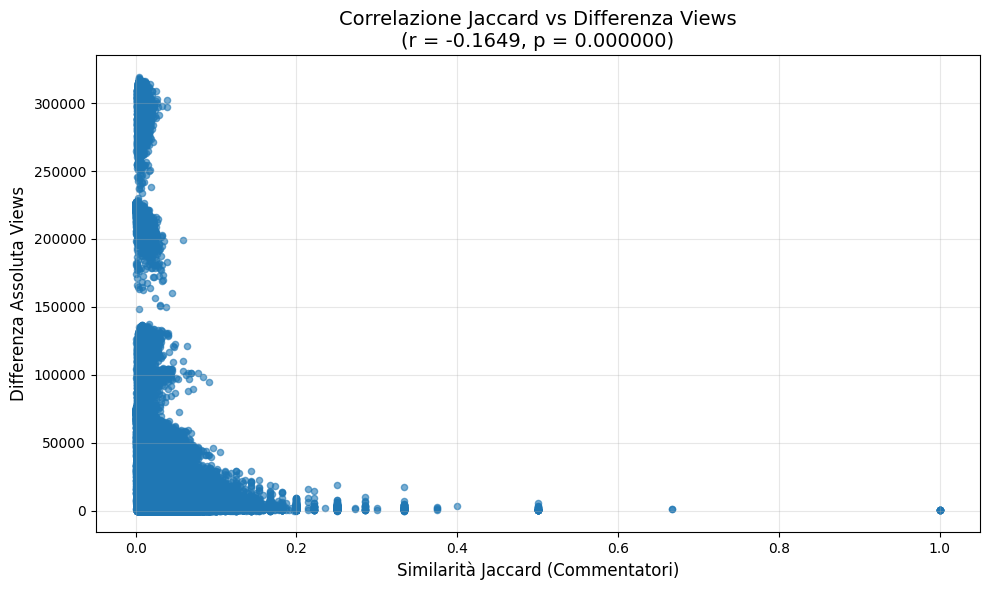

In [53]:
correlation, p_value = pearsonr(jaccard_sims, view_diffs)

print(f"=== Correlazione Similarità Jaccard vs Differenza Views ===")
print(f"Correlazione di Pearson: {correlation:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Numero di coppie analizzate: {len(jaccard_sims)}")

# Statistiche descrittive
print(f"\n=== Statistiche Similarità Jaccard ===")
print(f"Media: {np.mean(jaccard_sims):.4f}")
print(f"Mediana: {np.median(jaccard_sims):.4f}")
print(f"Min: {np.min(jaccard_sims):.4f}")
print(f"Max: {np.max(jaccard_sims):.4f}")

print(f"\n=== Statistiche Differenza Views ===")
print(f"Media: {np.mean(view_diffs):.0f}")
print(f"Mediana: {np.median(view_diffs):.0f}")
print(f"Min: {np.min(view_diffs):.0f}")
print(f"Max: {np.max(view_diffs):.0f}")

plt.figure(figsize=(10, 6))
plt.scatter(jaccard_sims, view_diffs, alpha=0.6, s=20)
plt.xlabel('Similarità Jaccard (Commentatori)', fontsize=12)
plt.ylabel('Differenza Assoluta Views', fontsize=12)
plt.title(f'Correlazione Jaccard vs Differenza Views\n(r = {correlation:.4f}, p = {p_value:.6f})', fontsize=14)
plt.grid(True, alpha=0.3)

# z = np.polyfit(jaccard_sims, view_diffs, 1)
# p = np.poly1d(z)
# plt.plot(jaccard_sims, p(jaccard_sims), "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()

Community detection sui video attraverso Gephi

In [8]:
results_dict = {}
with open("../progetto/colonne.csv", "r") as csvfile:
    reader = csv.DictReader(csvfile)
    headers = next(reader)
    for row in reader:
        channel = row["0"]
        modularity_class = row["modularity_class"]
        if channel not in results_dict:
            results_dict[channel] = {}
        if modularity_class not in results_dict[channel]:
            results_dict[channel][modularity_class] = 0
        results_dict[channel][modularity_class] += 1
        
percentage_dict = {}
for channel, classes in results_dict.items():
    total = sum(classes.values())
    percentage_dict[channel] = {k: v / total * 100 for k, v in classes.items()}

for channel, percentages in percentage_dict.items():
    print(f"Canale: {channel}")
    for modularity_class, percentage in percentages.items():
        print(f"  Community {modularity_class}: {percentage:.2f}%")
    print()


Canale: Romeo Agresti
  Community 0: 99.82%
  Community 1: 0.18%

Canale: Il BiancoNero
  Community 0: 64.79%
  Community 1: 20.71%
  Community 2: 7.83%
  Community 3: 6.21%
  Community 4: 0.46%

Canale: Colpo Gobbo
  Community 1: 98.83%
  Community 2: 0.34%
  Community 3: 0.67%
  Community 0: 0.17%

Canale: Luca Toselli
  Community 2: 99.40%
  Community 0: 0.20%
  Community 3: 0.20%
  Community 1: 0.20%

Canale: lAngolodiKinoshi
  Community 3: 99.53%
  Community 1: 0.32%
  Community 2: 0.16%



In [10]:
nx.write_gexf(G, "../progetto/cocommentatori_con_modularity.gexf")

In [26]:
degree = dict(G.degree())
degree_list = list(degree.values())
print(f'Grado medio: {np.mean(degree_list):.2f}')
print(f'Mediana: {np.median(degree_list)}')
print(f'Grado Minimo: {min(degree_list)}')
print(f'Grado Massimo: {max(degree_list)}')

Grado medio: 1857.29
Mediana: 2194.0
Grado Minimo: 1
Grado Massimo: 2946


Caratteristiche della rete

In [25]:
print(len(G.nodes), len(G.edges))
density = nx.density(G)
print(f"Densità del grafo: {density:.4f}")
clustering_coefficient = nx.transitivity(G)
print(f"Coefficiente di clustering: {clustering_coefficient:.4f}")
average_clustering_coefficient = nx.average_clustering(G)
print(f"Coefficiente di clustering medio: {average_clustering_coefficient:.4f}")

3284 3049663
Densità del grafo: 0.5657
Coefficiente di clustering: 0.7955
Coefficiente di clustering medio: 0.8142


Text(0, 0.5, 'P(X>x)')

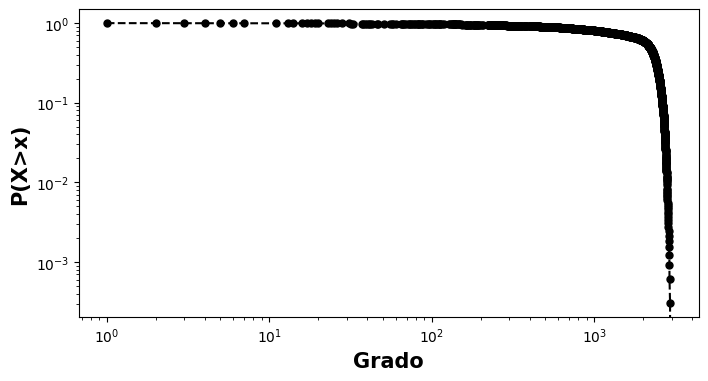

In [27]:
cdf_function = ECDF(degree_list)
x = np.unique(degree_list)
y = cdf_function(x)

# Visualizzazione
fig_cdf_function = plt.figure(figsize=(8,4))
assi = fig_cdf_function.gca()
assi.loglog(x,1-y,color = 'black', linestyle = '--', marker= 'o',ms = 5)
assi.set_xlabel('Grado',size=15, weight = 'bold')
assi.set_ylabel('P(X>x)',size=15, weight = 'bold')

In [13]:
media_pesi = 0
media_pesi_stesso_canale = 0
counter = 0

for channel in channels:
    media_pesi = 0
    media_pesi_stesso_canale = 0
    counter = 0
    for edge in G.edges(data=True):
        sorgente = edge[0]
        destinazione = edge[1]
        if G.nodes[sorgente]['channel'] == channel and G.nodes[destinazione]['channel'] == channel:
            media_pesi_stesso_canale += edge[2]['weight']
            counter += 1
        elif (G.nodes[edge[0]]['channel'] == channel or G.nodes[edge[1]]['channel'] == channel) and not (G.nodes[edge[0]]['channel'] == channel and G.nodes[edge[1]]['channel'] == channel):
            media_pesi += edge[2]['weight']
    if counter > 0:
        media_pesi_stesso_canale /= counter
    else:
        media_pesi_stesso_canale = 0
    # count edges involving this channel but not both nodes in the same channel
    total_other_edges = sum(
        1 for edge in G.edges(data=True)
        if (G.nodes[edge[0]]['channel'] == channel or G.nodes[edge[1]]['channel'] == channel)
        and not (G.nodes[edge[0]]['channel'] == channel and G.nodes[edge[1]]['channel'] == channel)
    )
    if total_other_edges > 0:
        media_pesi /= total_other_edges
    else:
        media_pesi = 0
    print(f"Canale: {channel}")
    print(f"  Media pesi con gli altri canali: {media_pesi: .2f}" )
    print(f"  Media pesi stesso canale:{media_pesi_stesso_canale: .2f}" )

Canale: Romeo Agresti
  Media pesi con gli altri canali:  3.58
  Media pesi stesso canale: 13.88
Canale: Il BiancoNero
  Media pesi con gli altri canali:  1.77
  Media pesi stesso canale: 1.36
Canale: Colpo Gobbo
  Media pesi con gli altri canali:  3.82
  Media pesi stesso canale: 10.77
Canale: Luca Toselli
  Media pesi con gli altri canali:  3.34
  Media pesi stesso canale: 9.11
Canale: lAngolodiKinoshi
  Media pesi con gli altri canali:  2.92
  Media pesi stesso canale: 5.89


In [ ]:
# Calcolo della modularità basata sull'attributo 'channel'
# La modularità misura quanto bene i canali formano comunità distinte

channel_partition = {}
for node in G.nodes():
    channel = G.nodes[node]['channel']
    if channel not in channel_partition:
        channel_partition[channel] = []
    channel_partition[channel].append(node)

partition_list = [set(nodes) for nodes in channel_partition.values()]

modularity_channel = nx.community.modularity(G, partition_list)
print(f"\nModularità basata sui canali: {modularity_channel:.4f}")


Modularità basata sui canali: 0.2211
Moderata modularità: i canali mostrano una certa struttura comunitaria


In [ ]:
intra_channel_edges = 0
inter_channel_edges = 0
intra_channel_weights = []
inter_channel_weights = []

for edge in G.edges(data=True):
    node1, node2, data = edge
    channel1 = G.nodes[node1]['channel']
    channel2 = G.nodes[node2]['channel']
    weight = data['weight']
    
    if channel1 == channel2:
        intra_channel_edges += 1
        intra_channel_weights.append(weight)
    else:
        inter_channel_edges += 1
        inter_channel_weights.append(weight)

print(f"\n=== Analisi delle connessioni ===")
print(f"Connessioni intra-canale: {intra_channel_edges}")
print(f"Connessioni inter-canale: {inter_channel_edges}")
print(f"Percentuale intra-canale: {intra_channel_edges/(intra_channel_edges+inter_channel_edges)*100:.2f}%")
print(f"Percentuale inter-canale: {inter_channel_edges/(intra_channel_edges+inter_channel_edges)*100:.2f}%")

if intra_channel_weights:
    print(f"\nPeso medio connessioni intra-canale: {np.mean(intra_channel_weights):.2f}")
if inter_channel_weights:
    print(f"Peso medio connessioni inter-canale: {np.mean(inter_channel_weights):.2f}")

# Matrice di adiacenza tra canali
channel_connections = {}
for channel1 in channels:
    channel_connections[channel1] = {}
    for channel2 in channels:
        channel_connections[channel1][channel2] = 0

for edge in G.edges(data=True):
    node1, node2, data = edge
    channel1 = G.nodes[node1]['channel']
    channel2 = G.nodes[node2]['channel']
    weight = data['weight']
    
    channel_connections[channel1][channel2] += weight
    if channel1 != channel2:
        channel_connections[channel2][channel1] += weight

print(f"\n=== Matrice delle connessioni tra canali (peso totale) ===")
print(f"{'':20s}", end="")
for channel in channels:
    print(f"{channel[:15]:>15s}", end="")
print()

for channel1 in channels:
    print(f"{channel1[:20]:20s}", end="")
    for channel2 in channels:
        print(f"{channel_connections[channel1][channel2]:>15.0f}", end="")
    print()


=== Analisi delle connessioni ===
Connessioni intra-canale: 726322
Connessioni inter-canale: 2323341
Percentuale intra-canale: 23.82%
Percentuale inter-canale: 76.18%

Peso medio connessioni intra-canale: 8.61
Peso medio connessioni inter-canale: 3.16

=== Matrice delle connessioni tra canali (peso totale) ===
                      Romeo Agresti  Il BiancoNero    Colpo Gobbo   Luca TosellilAngolodiKinosh
Romeo Agresti               2249111         556757        1568855         865989         985523
Il BiancoNero                556757         140315         355810         184002         204265
Colpo Gobbo                 1568855         355810        1776185         894511        1021070
Luca Toselli                 865989         184002         894511         969715         708246
lAngolodiKinoshi             985523         204265        1021070         708246        1119696


In [ ]:
connection_counts = {}
for channel1 in channels:
    connection_counts[channel1] = {}
    for channel2 in channels:
        connection_counts[channel1][channel2] = 0

for edge in G.edges(data=True):
    node1, node2, data = edge
    channel1 = G.nodes[node1]['channel']
    channel2 = G.nodes[node2]['channel']
    
    connection_counts[channel1][channel2] += 1

average_weights = {}
for channel1 in channels:
    average_weights[channel1] = {}
    for channel2 in channels:
        total_weight = channel_connections[channel1][channel2]
        num_connections = connection_counts[channel1][channel2]
        
        if num_connections > 0:
            avg_weight = total_weight / num_connections
            average_weights[channel1][channel2] = avg_weight
        else:
            average_weights[channel1][channel2] = 0.0

print("=== Peso medio delle connessioni tra coppie di canali ===")
print(f"{'':20s}", end="")
for channel in channels:
    print(f"{channel[:15]:>15s}", end="")
print()

for channel1 in channels:
    print(f"{channel1[:20]:20s}", end="")
    for channel2 in channels:
        print(f"{average_weights[channel1][channel2]:>15.2f}", end="")
    print()

print("\n=== Analisi dettagliata connessioni inter-canale ===")
for i, channel1 in enumerate(channels):
    for j, channel2 in enumerate(channels):
        if i <= j:  # Evita duplicati (mostra solo triangolo superiore)
            total_weight = channel_connections[channel1][channel2]
            num_connections = connection_counts[channel1][channel2]
            avg_weight = average_weights[channel1][channel2]
            
            print(f"\n{channel1} <-> {channel2}:")
            print(f"  Numero connessioni: {num_connections}")
            print(f"  Peso totale: {total_weight}")
            print(f"  Peso medio: {avg_weight:.2f}")


=== Peso medio delle connessioni tra coppie di canali ===
                      Romeo Agresti  Il BiancoNero    Colpo Gobbo   Luca TosellilAngolodiKinosh
Romeo Agresti                 13.88           2.02           5.35           3.85           3.12
Il BiancoNero                  2.02           1.36           1.79           1.58           1.40
Colpo Gobbo                    5.35           1.79          10.77           4.17           3.40
Luca Toselli                   3.85           1.58           4.17           9.11           2.98
lAngolodiKinoshi               3.12           1.40           3.40           2.98           5.89

=== Analisi dettagliata connessioni inter-canale ===

Romeo Agresti <-> Romeo Agresti:
  Numero connessioni: 162049
  Peso totale: 2249111.0
  Peso medio: 13.88

Romeo Agresti <-> Il BiancoNero:
  Numero connessioni: 275650
  Peso totale: 556757.0
  Peso medio: 2.02

Romeo Agresti <-> Colpo Gobbo:
  Numero connessioni: 293277
  Peso totale: 1568855.0
  Peso medio

In [9]:
connessioni_BN = channel_connections["Il BiancoNero"]
total_connections_BN = sum(connessioni_BN.values())

for channel in channels:
    print(f"\n=== Connessioni per {channel} ===")
    connessionis = channel_connections[channel]
    total_connections = sum(connessionis.values())
    for channel1 in channels:
        connessioni = connessionis[channel1]
        percentuale = (connessioni / total_connections) * 100 if total_connections_BN > 0 else 0
        print(f"{channel1[:15]}: {percentuale:.2f}%")
        


=== Connessioni per Romeo Agresti ===
Romeo Agresti: 36.12%
Il BiancoNero: 8.94%
Colpo Gobbo: 25.20%
Luca Toselli: 13.91%
lAngolodiKinosh: 15.83%

=== Connessioni per Il BiancoNero ===
Romeo Agresti: 38.63%
Il BiancoNero: 9.74%
Colpo Gobbo: 24.69%
Luca Toselli: 12.77%
lAngolodiKinosh: 14.17%

=== Connessioni per Colpo Gobbo ===
Romeo Agresti: 27.93%
Il BiancoNero: 6.34%
Colpo Gobbo: 31.62%
Luca Toselli: 15.93%
lAngolodiKinosh: 18.18%

=== Connessioni per Luca Toselli ===
Romeo Agresti: 23.91%
Il BiancoNero: 5.08%
Colpo Gobbo: 24.69%
Luca Toselli: 26.77%
lAngolodiKinosh: 19.55%

=== Connessioni per lAngolodiKinoshi ===
Romeo Agresti: 24.40%
Il BiancoNero: 5.06%
Colpo Gobbo: 25.28%
Luca Toselli: 17.54%
lAngolodiKinosh: 27.72%


il 26% dei video del bianconero uniti a community di altri sono una collaborazione con il canale a cui è stato accorpato

In [22]:
# pearson correlation coefficient on views
assortativity_views = nx.numeric_assortativity_coefficient(G, 'views')
print(f"\nCoefficiente di assortatività basato sulle visualizzazioni: {assortativity_views:.4f}")
if assortativity_views > 0.1:
    print("La rete mostra una tendenza assortativa (nodi simili si connettono).")
elif assortativity_views < -0.1:
    print("La rete mostra una tendenza disassortativa (nodi dissimili si connettono).")
else:
    print("La rete non mostra una forte tendenza assortativa o disassortativa.")
# pearson correlation coefficient on degree
assortativity_degree = nx.degree_assortativity_coefficient(G)
print(f"Coefficiente di assortatività basato sul grado: {assortativity_degree:.4f}")
if assortativity_degree > 0.1:
    print("La rete mostra una tendenza assortativa (nodi simili si connettono).")
elif assortativity_degree < -0.1:
    print("La rete mostra una tendenza disassortativa (nodi dissimili si connettono).")
else:
    print("La rete non mostra una forte tendenza assortativa o disassortativa.")
        



Coefficiente di assortatività basato sulle visualizzazioni: -0.0037
La rete non mostra una forte tendenza assortativa o disassortativa.
Coefficiente di assortatività basato sul grado: -0.0432
La rete non mostra una forte tendenza assortativa o disassortativa.


Proiezione sui commentatori

In [ ]:
G_utenti = nx.Graph()
utenti = Videos_commented_by.keys()
for user1, user2 in combinations(utenti, 2):
    videos1 = Videos_commented_by[user1]
    videos2 = Videos_commented_by[user2]
    common_videos = videos1.intersection(videos2)
    common_videos = common_videos.intersection(total_videos)
    if len(common_videos) > 0:
        G_utenti.add_edge(user1, user2, weight=len(common_videos))
for n in G_utenti.nodes:
    videos = Videos_commented_by[n]
    if len(videos) == 1:
        G_utenti.nodes[n]['video'] = videos.pop()
       
nx.write_gexf(G_utenti,"co-commentatori_utenti_piu_grande_con_info.gexf")

In [6]:
G_utenti = nx.read_gexf("../progetto/co-commentatori_utenti_piu_grande_con_info.gexf")

In [13]:
degree = dict(G_utenti.degree())
degree_list = list(degree.values())
print(f'Grado medio: {np.mean(degree_list):.2f}')
print(f'Mediana: {np.median(degree_list)}')
print(f'Grado Minimo: {min(degree_list)}')
print(f'Grado Massimo: {max(degree_list)}')

Grado medio: 736.78
Mediana: 484.0
Grado Minimo: 3
Grado Massimo: 7389


Text(0, 0.5, 'P(X>x)')

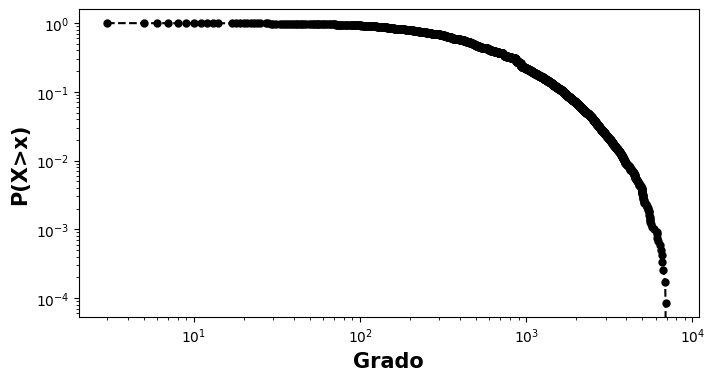

In [14]:
cdf_function = ECDF(degree_list)
x = np.unique(degree_list)
y = cdf_function(x)

# Visualizzazione
fig_cdf_function = plt.figure(figsize=(8,4))
assi = fig_cdf_function.gca()
assi.loglog(x,1-y,color = 'black', linestyle = '--', marker= 'o',ms = 5)
assi.set_xlabel('Grado',size=15, weight = 'bold')
assi.set_ylabel('P(X>x)',size=15, weight = 'bold')

In [17]:
print(len(G_utenti.nodes), len(G_utenti.edges))
density = nx.density(G_utenti)
print(f"Densità del grafo: {density:.4f}")
average_clustering_coefficient = nx.average_clustering(G_utenti)
clustering_coefficient = nx.transitivity(G_utenti)
print(f"Coefficiente di clustering: {clustering_coefficient:.4f}")
print(f"Coefficiente di clustering medio: {average_clustering_coefficient:.4f}")

11873 4373890
Densità del grafo: 0.0621
Coefficiente di clustering: 0.3951
Coefficiente di clustering medio: 0.7857


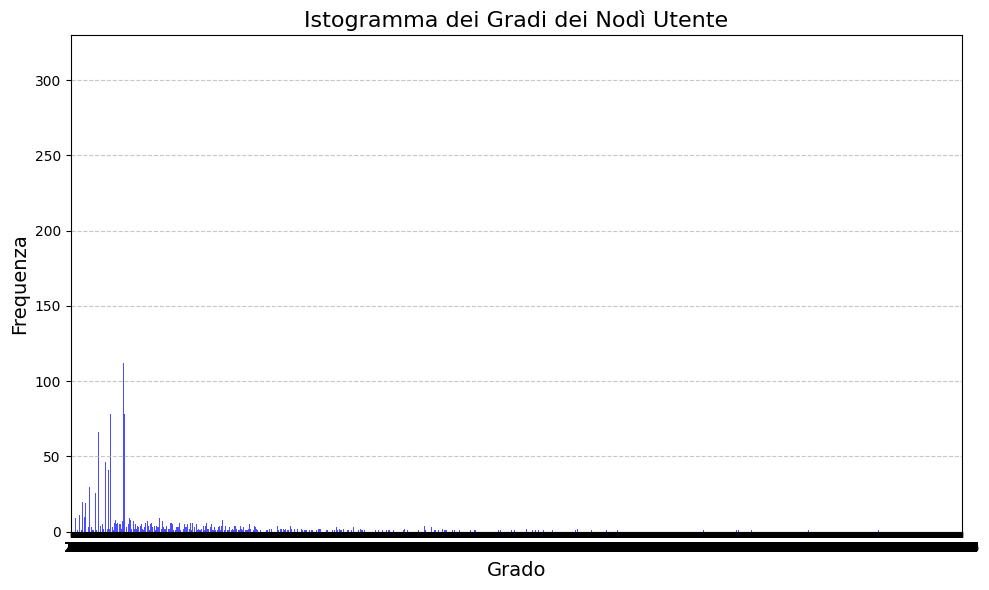

In [ ]:
histogram = nx.degree_histogram(G_utenti)
plt.figure(figsize=(10, 6))
plt.bar(range(len(histogram)), histogram, width=0.8, color='blue', alpha=0.7)
plt.xlabel('Grado', fontsize=14)
plt.ylabel('Frequenza', fontsize=14)
plt.title('Istogramma dei Gradi dei Nodi Utente', fontsize=16)
plt.xticks(range(len(histogram)))
plt.xlim(0, len(histogram) - 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()